# Garnet Lattice-Gas Monte Carlo Simulation Data Analysis

This notebook contains the data analysis for a series of lattice-gas Monte Carlo simulations performed for a garnet-structure lattice. The simulations have been performed using the [`lattice_mc`](https://github.com/bjmorgan/lattice_mc) code \[1\].  

Simulations were performed for an ideal $2\times2\times2$ garnet lattice, containing 384 octahedral sites and 192 tetrahedral sites. The lattice site coordinates were generated from the cubic high-temperature Li<sub>7</sub>La<sub>3</sub>Zr<sub>2</sub>O<sub>12</sub> (LLZO) structure ([ICSD #422259]()) \[3\]. Octahedral and tetrahderal lattice site coordinates were defined using the centres of the respective polyhedra defined by the oxide sub-lattice. This construction considers each octahedron as a single $48g$ site. The network of diffusion pathways consists of connections between all nearest-neighbour tetrahedron–octahedron pairs. 

For each simulation, $n_\mathrm{Li}$ mobile particles are initially randomly distributed across the lattice sites. Equilibration consists of 1000 simulation steps, followed by 10,000 step production steps. 

The simulation methods are described in [Correlated Transport in Garnet Solid Electrolytes: A Lattice-Gas Monte Carlo Simulation Study]() \[2\].

## References

1. B. J. Morgan, *`lattice_mc`: A Python Lattice-Gas Monte Carlo Module*, [J. Open Source Software, 2, 00247 (2017)](https://doi.org/10.21105/joss.00247)
2. B. J. Morgan, *Correlated Transport in Garnet Solid Electrolytes: A Lattice-Gas Monte Carlo Simulation Study*, In Preparation. 
3. J. Awaka, A. Takashima, K. Kataoka, N. Kijima, Y. Idemoto, J. Akimoto, Chem. Lett. 40, 60 (2011).

In [1]:
import sys
import numpy as np
import pandas as pd
import scipy.ndimage
from scipy import interpolate
from scipy import stats

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'

import figure_formatting
from figure_formatting import fontsize

The simulation data are recorded in `../data/garnet_data.csv`.  

Each entry contains the following information:

| label    | data |
|----------|------|
| `n_Li`   | Number of mobile particles on the lattice (representing lithium ions).  |
| `E_nn`   | Nearest-neighbour repulsion energy (in units of $kT$). |
| `E_site` | Relative energy to occupy an octahedral versus tetrahedral site. |
| `f`      | Single-particle correlation factor. |
| `f_I`    | Collective correlation factor. |
| `D_t`    | Tracer diffusion coefficient. |
| `D_coll` | Collective diffusion coefficient. |
| `n_oct`  | Average number of particles occupying octahedral sites. |
| `n_tet`  | Average number of particles occupying tetrahedral aites. |

In [3]:
filename = '../data/garnet_data.csv'
index = np.array( [ 'n_Li', 'E_nn', 'E_site', 'f', 'f_I', 'D_t', 'D_coll', 'n_oct', 'n_tet' ] )
data = pd.read_csv( filename, delim_whitespace = True, names = index, header = None, comment = '#' )
data.head()

,n_Li,E_nn,E_site,f,f_I,D_t,D_coll,n_oct,n_tet
0,1,0.0,0.0,1.010,1.010,6.352000e-07,6.352000e-07,0.67,0.33
1,32,0.0,0.0,0.948,0.999,5.643000e-07,5.947000e-07,21.33,10.67
2,64,0.0,0.0,0.902,0.995,5.053000e-07,5.577000e-07,42.67,21.33
3,96,0.0,0.0,0.856,1.005,4.495000e-07,5.281000e-07,64.01,31.99
4,128,0.0,0.0,0.808,0.999,3.965000e-07,4.898000e-07,85.34,42.66


Calculate some other data:

| column | data |
|--------|------|
| `H_R` | Haven ratio. |
| `site_ratio` | Ratio of octahedral to tetrahedral occupied sites. |
| `sigma_eff` | Normalised ionic conductivity. |

In [4]:
data[ 'H_R' ] = data[ 'f' ] / data[ 'f_I' ]
data[ 'site_ratio' ] = data[ 'n_oct' ] / data[ 'n_tet' ]
data[ 'sigma_eff' ] = data[ 'D_coll' ] * data[ 'n_Li' ]

Rescale the number of mobile particles (lithium ions) to give the stoichiometry $x$ per formula unit in A<sub>$x$</sub>B<sub>3</sub>C<sub>2</sub>O<sub>12</sub>.

In [5]:
data.n_Li /= 64.0
data.n_oct /= 64.0
data.n_tet /= 64.0

In [6]:
data.head()

,n_Li,E_nn,E_site,f,f_I,D_t,D_coll,n_oct,n_tet,H_R,site_ratio,sigma_eff
0,0.015625,0.0,0.0,1.010,1.010,6.352000e-07,6.352000e-07,0.010469,0.005156,1.000000,2.030303,6.352000e-07
1,0.500000,0.0,0.0,0.948,0.999,5.643000e-07,5.947000e-07,0.333281,0.166719,0.948949,1.999063,1.903040e-05
2,1.000000,0.0,0.0,0.902,0.995,5.053000e-07,5.577000e-07,0.666719,0.333281,0.906533,2.000469,3.569280e-05
3,1.500000,0.0,0.0,0.856,1.005,4.495000e-07,5.281000e-07,1.000156,0.499844,0.851741,2.000938,5.069760e-05
4,2.000000,0.0,0.0,0.808,0.999,3.965000e-07,4.898000e-07,1.333438,0.666562,0.808809,2.000469,6.269440e-05


In [7]:
def my_plot( subplot, x, y, label=None ):
    subplot.plot( x, y, 'o-', markeredgewidth=0.0, clip_on=False, label=label )
    subplot.set_xticks( range(10) )

def setup_figure( subplot ):
#     subplot.set_facecolor("w")
#     subplot.grid(color='grey', linewidth = 0.3 )
    for s in [ 'top', 'bottom', 'left', 'right' ]:
        subplot.spines[ s ].set_color('grey')
        subplot.spines[ s ].set_linewidth(0.3)
    subplot.tick_params( axis ='both', which = 'both', length = 0, labelsize = 13 )

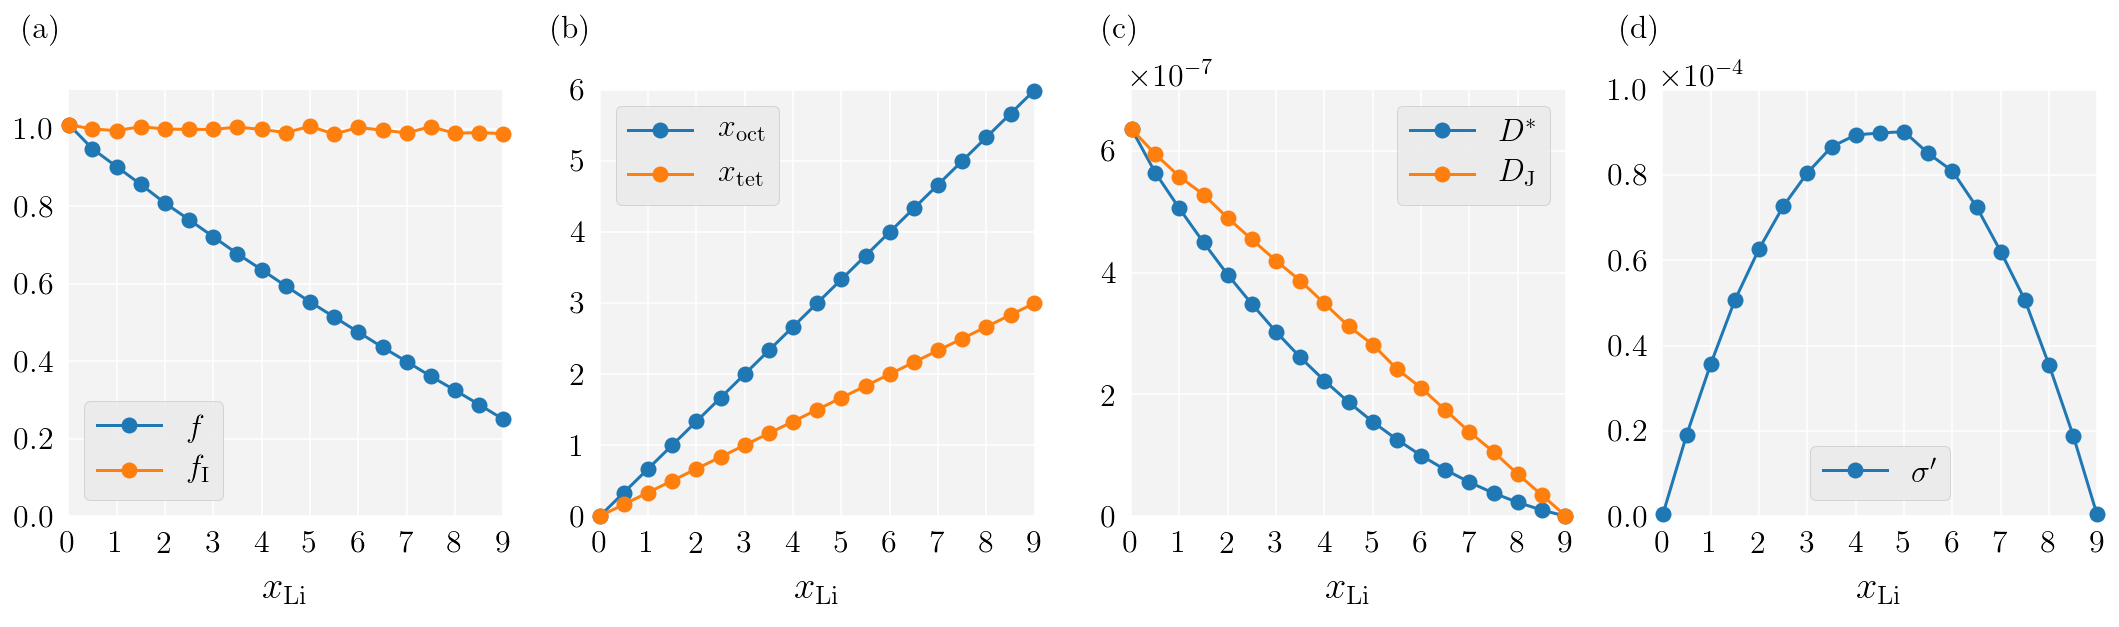

In [23]:
df = data.loc[ ( data.E_nn == 0.0 ) & ( data.E_site == 0.0 ) ]

fig, axs = plt.subplots(1,4, figsize=(15, 4.5))

correlation_plot = axs[0]
occupation_plot = axs[1]
diffusion_plot = axs[2]
conductivity_plot = axs[3]

for ax in [ correlation_plot, occupation_plot, diffusion_plot, conductivity_plot ]:
    setup_figure( ax )
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=fontsize)

# Plot single particle correlation and collective correlation factors.
ax = correlation_plot
my_plot( ax, df.n_Li, df.f, label=r'$f$' )
my_plot( ax, df.n_Li, df.f_I, label=r'$f_\mathrm{I}$' )
ax.set_xlabel(r'$x_\mathrm{Li}$')
ax.set_xlim([0,9.0])
ax.set_ylim([0.0,1.1])
ax.legend()

# Plot average occupation of octahedral and tetrahedral sites.
ax = occupation_plot
my_plot( ax, df.n_Li, df.n_oct, label=r'$x_\mathrm{oct}$' )
my_plot( ax, df.n_Li, df.n_tet, label=r'$x_\mathrm{tet}$' )
ax.set_xlabel(r'$x_\mathrm{Li}$')
ax.set_xlim([0,9.0])
ax.set_ylim([0,6])
# ax.set_yticks([0,100,200,300,384])
ax.legend()

# Plot the collective and tracer diffusion coefficients.
ax = diffusion_plot
my_plot( ax, df.n_Li, df.D_t,    label=r'$D^*$' )
my_plot( ax, df.n_Li, df.D_coll, label=r'$D_\mathrm{J}$' )
ax.set_xlabel(r'$x_\mathrm{Li}$')
ax.set_xlim([0,9.0])
ax.set_ylim([0,7e-7])
ax.legend()

# Plot the reduced ionic conductivity.
ax = conductivity_plot
my_plot( ax, df.n_Li, df.sigma_eff, label=r'$\sigma^\prime$' )
ax.set_xlabel(r'$x_\mathrm{Li}$')
ax.set_xlim([0,9.0])
ax.set_ylim([0,1e-4])
ax.legend(loc='lower center')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0) )

# Add labels for each panel.
fig.text(0.02,0.94,'(a)')
fig.text(0.265,0.94,'(b)')
fig.text(0.52,0.94,'(c)')
fig.text(0.76,0.94,'(d)')

plt.tight_layout()
plt.subplots_adjust(top=0.86)

# Save as PDF.
fig.savefig(filename = '../figures/non-interacting_data.pdf' )

(a) single particle correlation factor, $f$, and collective correlation factor, $f_\mathrm{I}$.  
(b) average occupations.  
(c) diffusion coefficients.  
(d) effective (reduced?) ionic conductivity, $\sigma^\prime$.

In [9]:
# R^2 for a straight line fit to the single particle correlation factor:
stats.linregress( df.n_Li/9, df.f ).rvalue**2

0.9973517078381422

In [11]:
def sub_plot( ax, df, x, y, x_range, y_range, log_plot=False ):
    df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
    ax.set_xlim( x_range )
    ax.set_ylim( y_range )
    ax.set_xticks(range(10))
    if not df.empty:
        if not log_plot:
            df.plot( x=x, y=y, ax=ax, legend=None )
        else:
            df.plot( x=x, y=y, ax=ax, legend=None, logy=True,  clip_on=False, zorder=100 )
        ax.set_xlabel('')

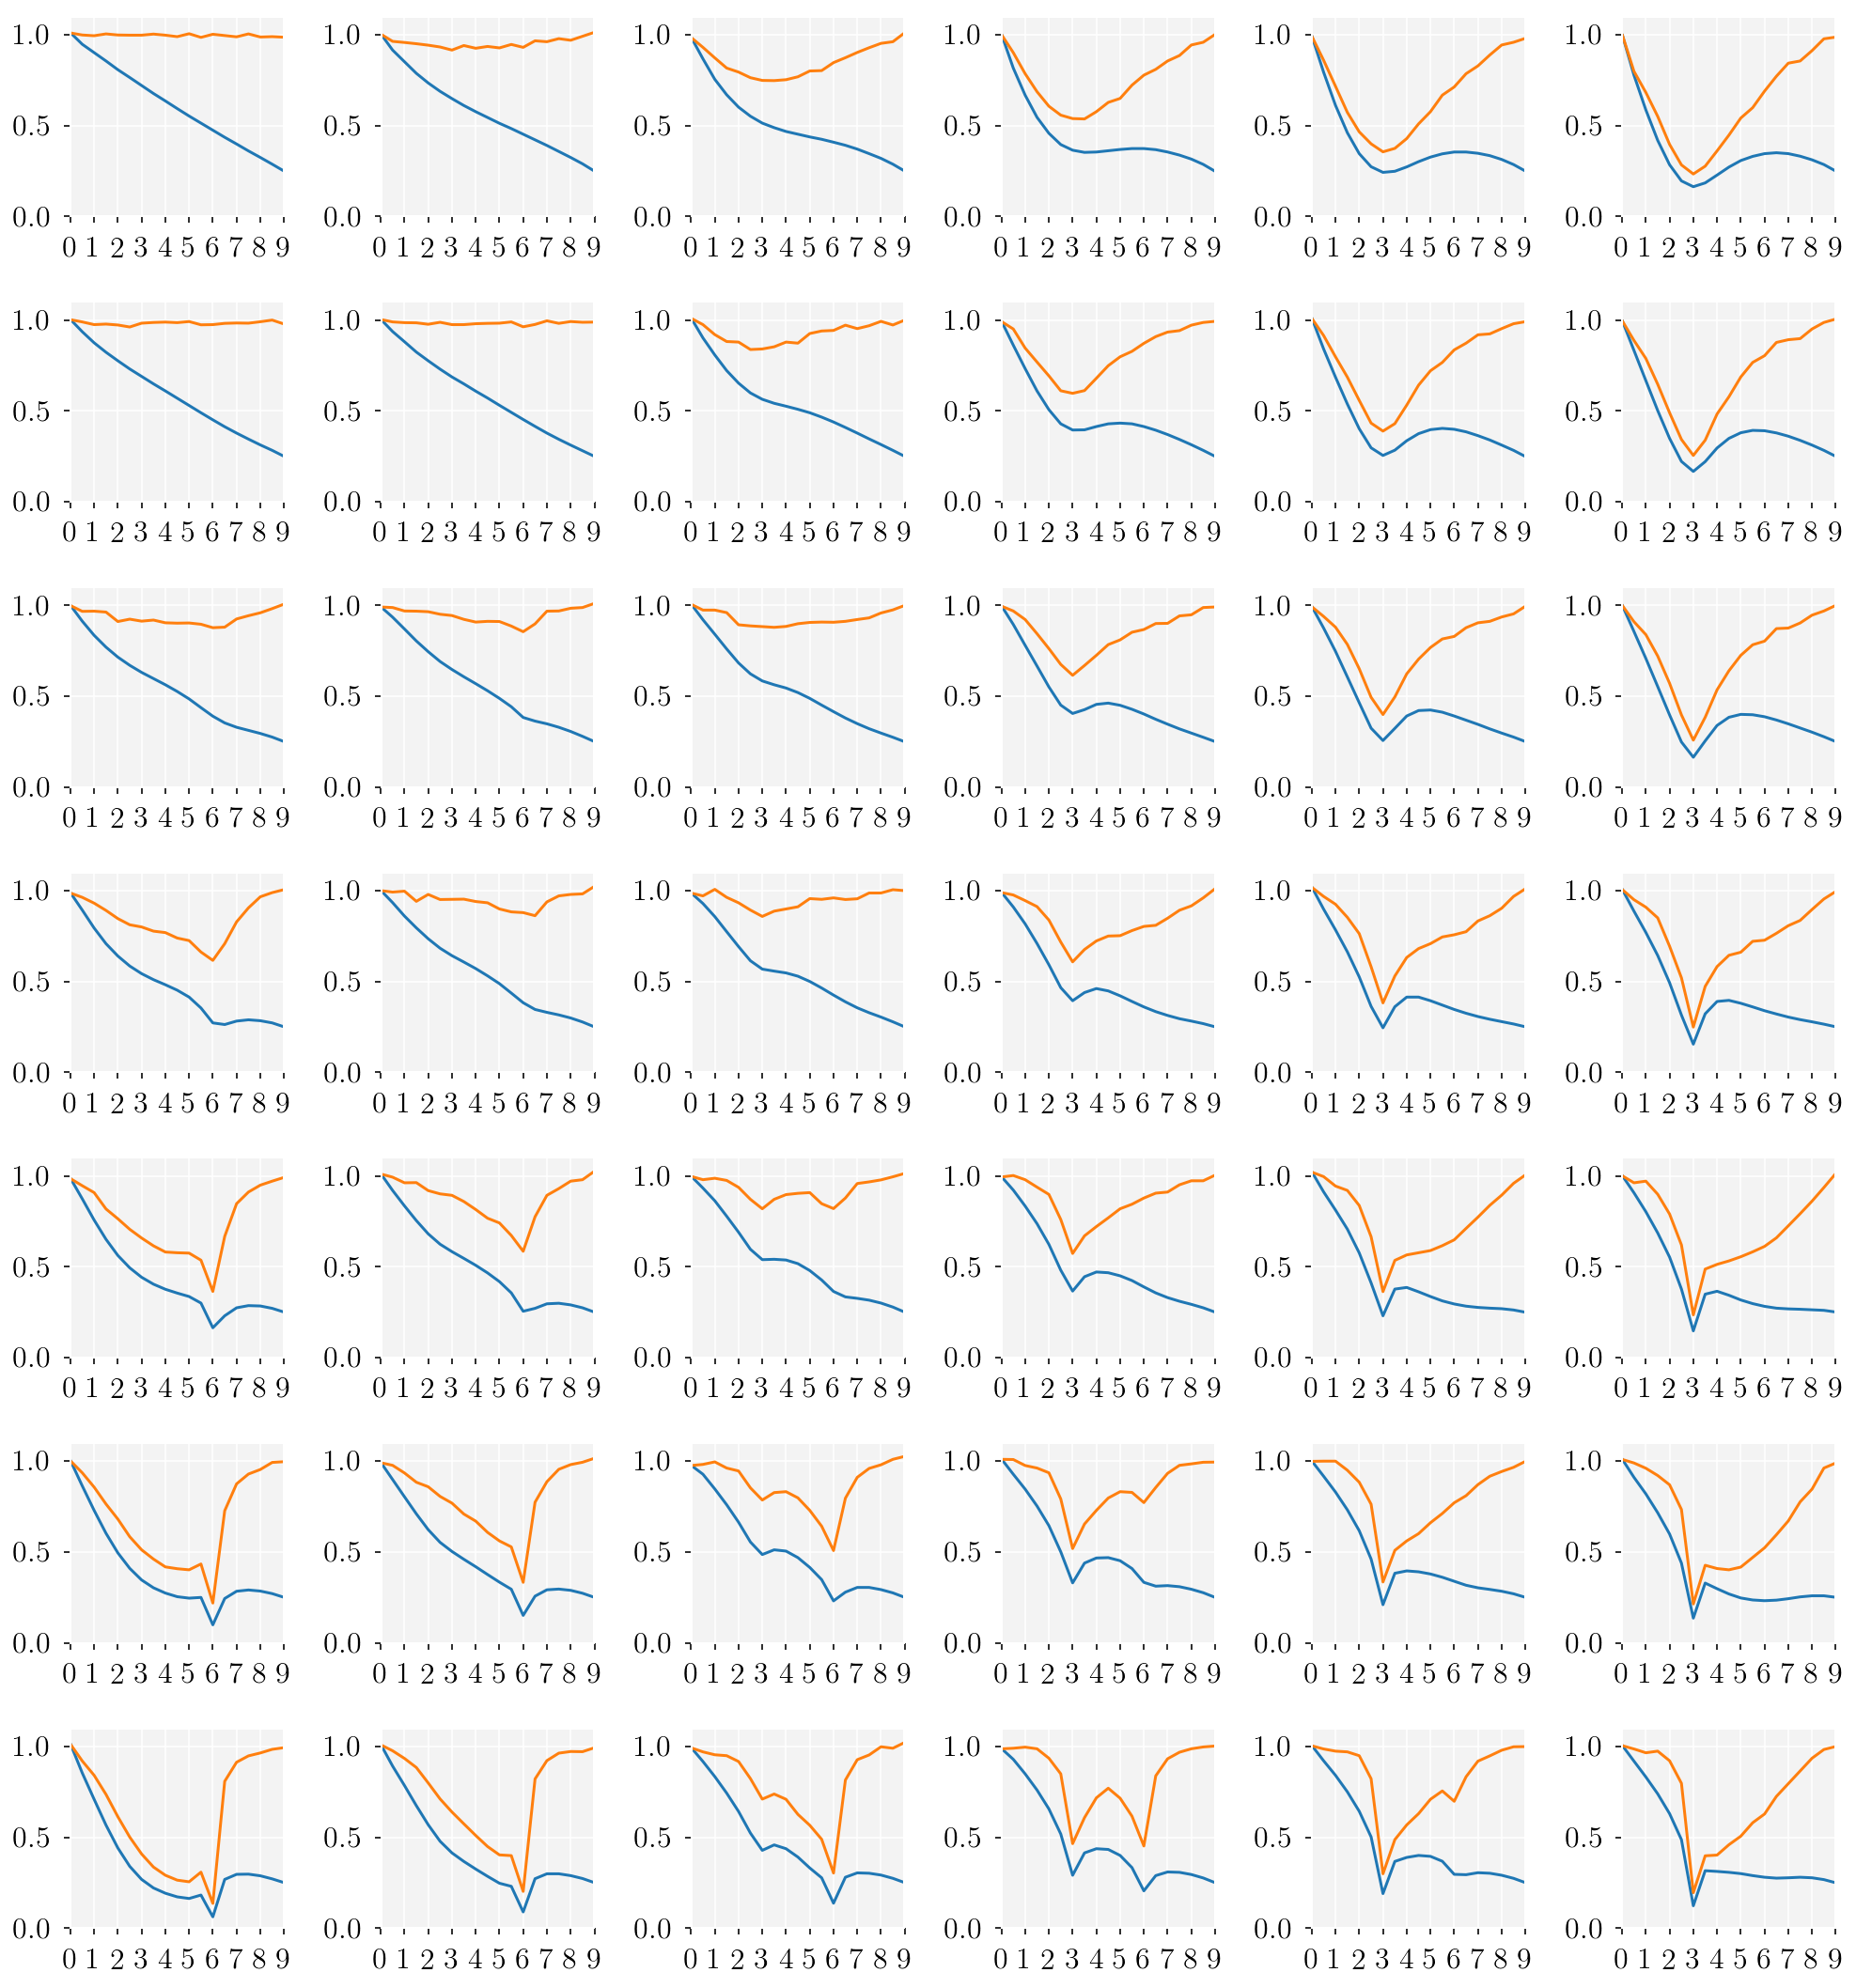

In [12]:
nn_energies = [ 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 ] 
site_energies = [ 0.0, 1.0, 2.0, 3.0, 4.0, 5.0 ]

fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (14, 15))
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=[ 'f', 'f_I' ], x_range=[0, 9.0], y_range=[0.0, 1.1] )
    
fig.tight_layout()
fig.savefig( filename = 'correlation_miniplots.pdf' )

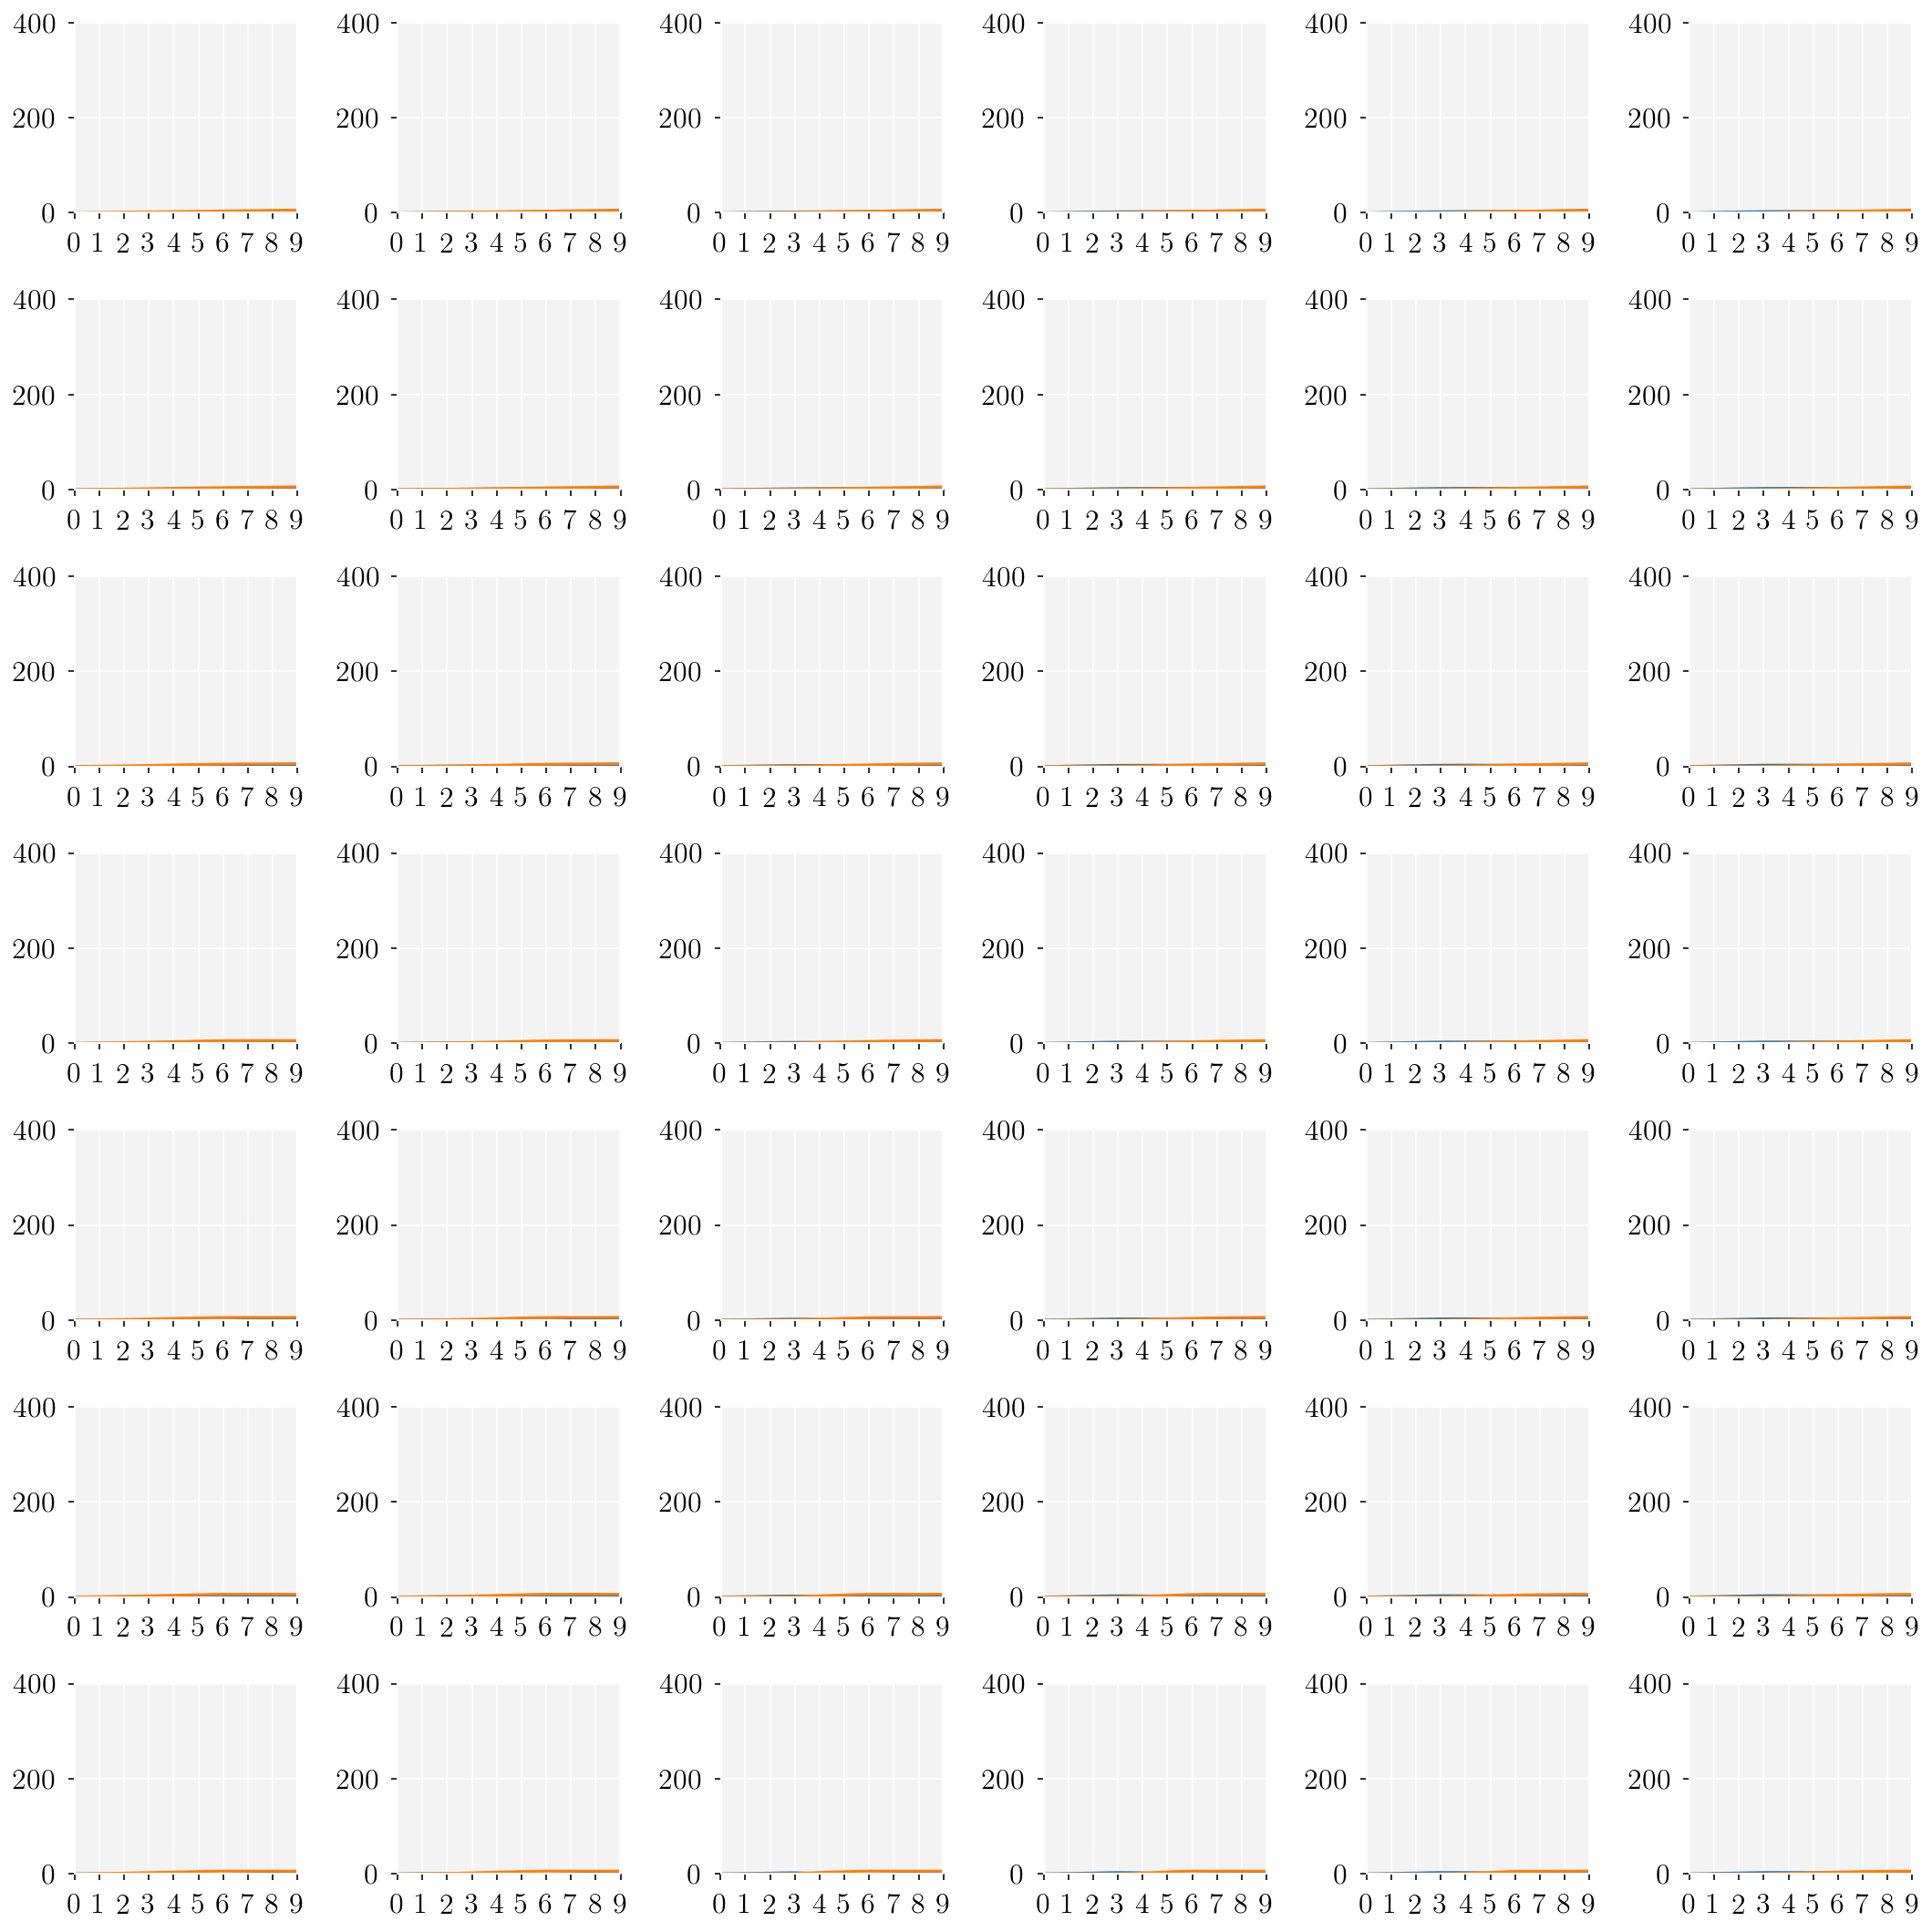

In [13]:
fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (15, 15))
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=['n_tet', 'n_oct'], x_range=[0, 9.0], y_range=[0,400] )
    
fig.tight_layout()
fig.savefig( filename = 'site_occupation_miniplots.pdf' )

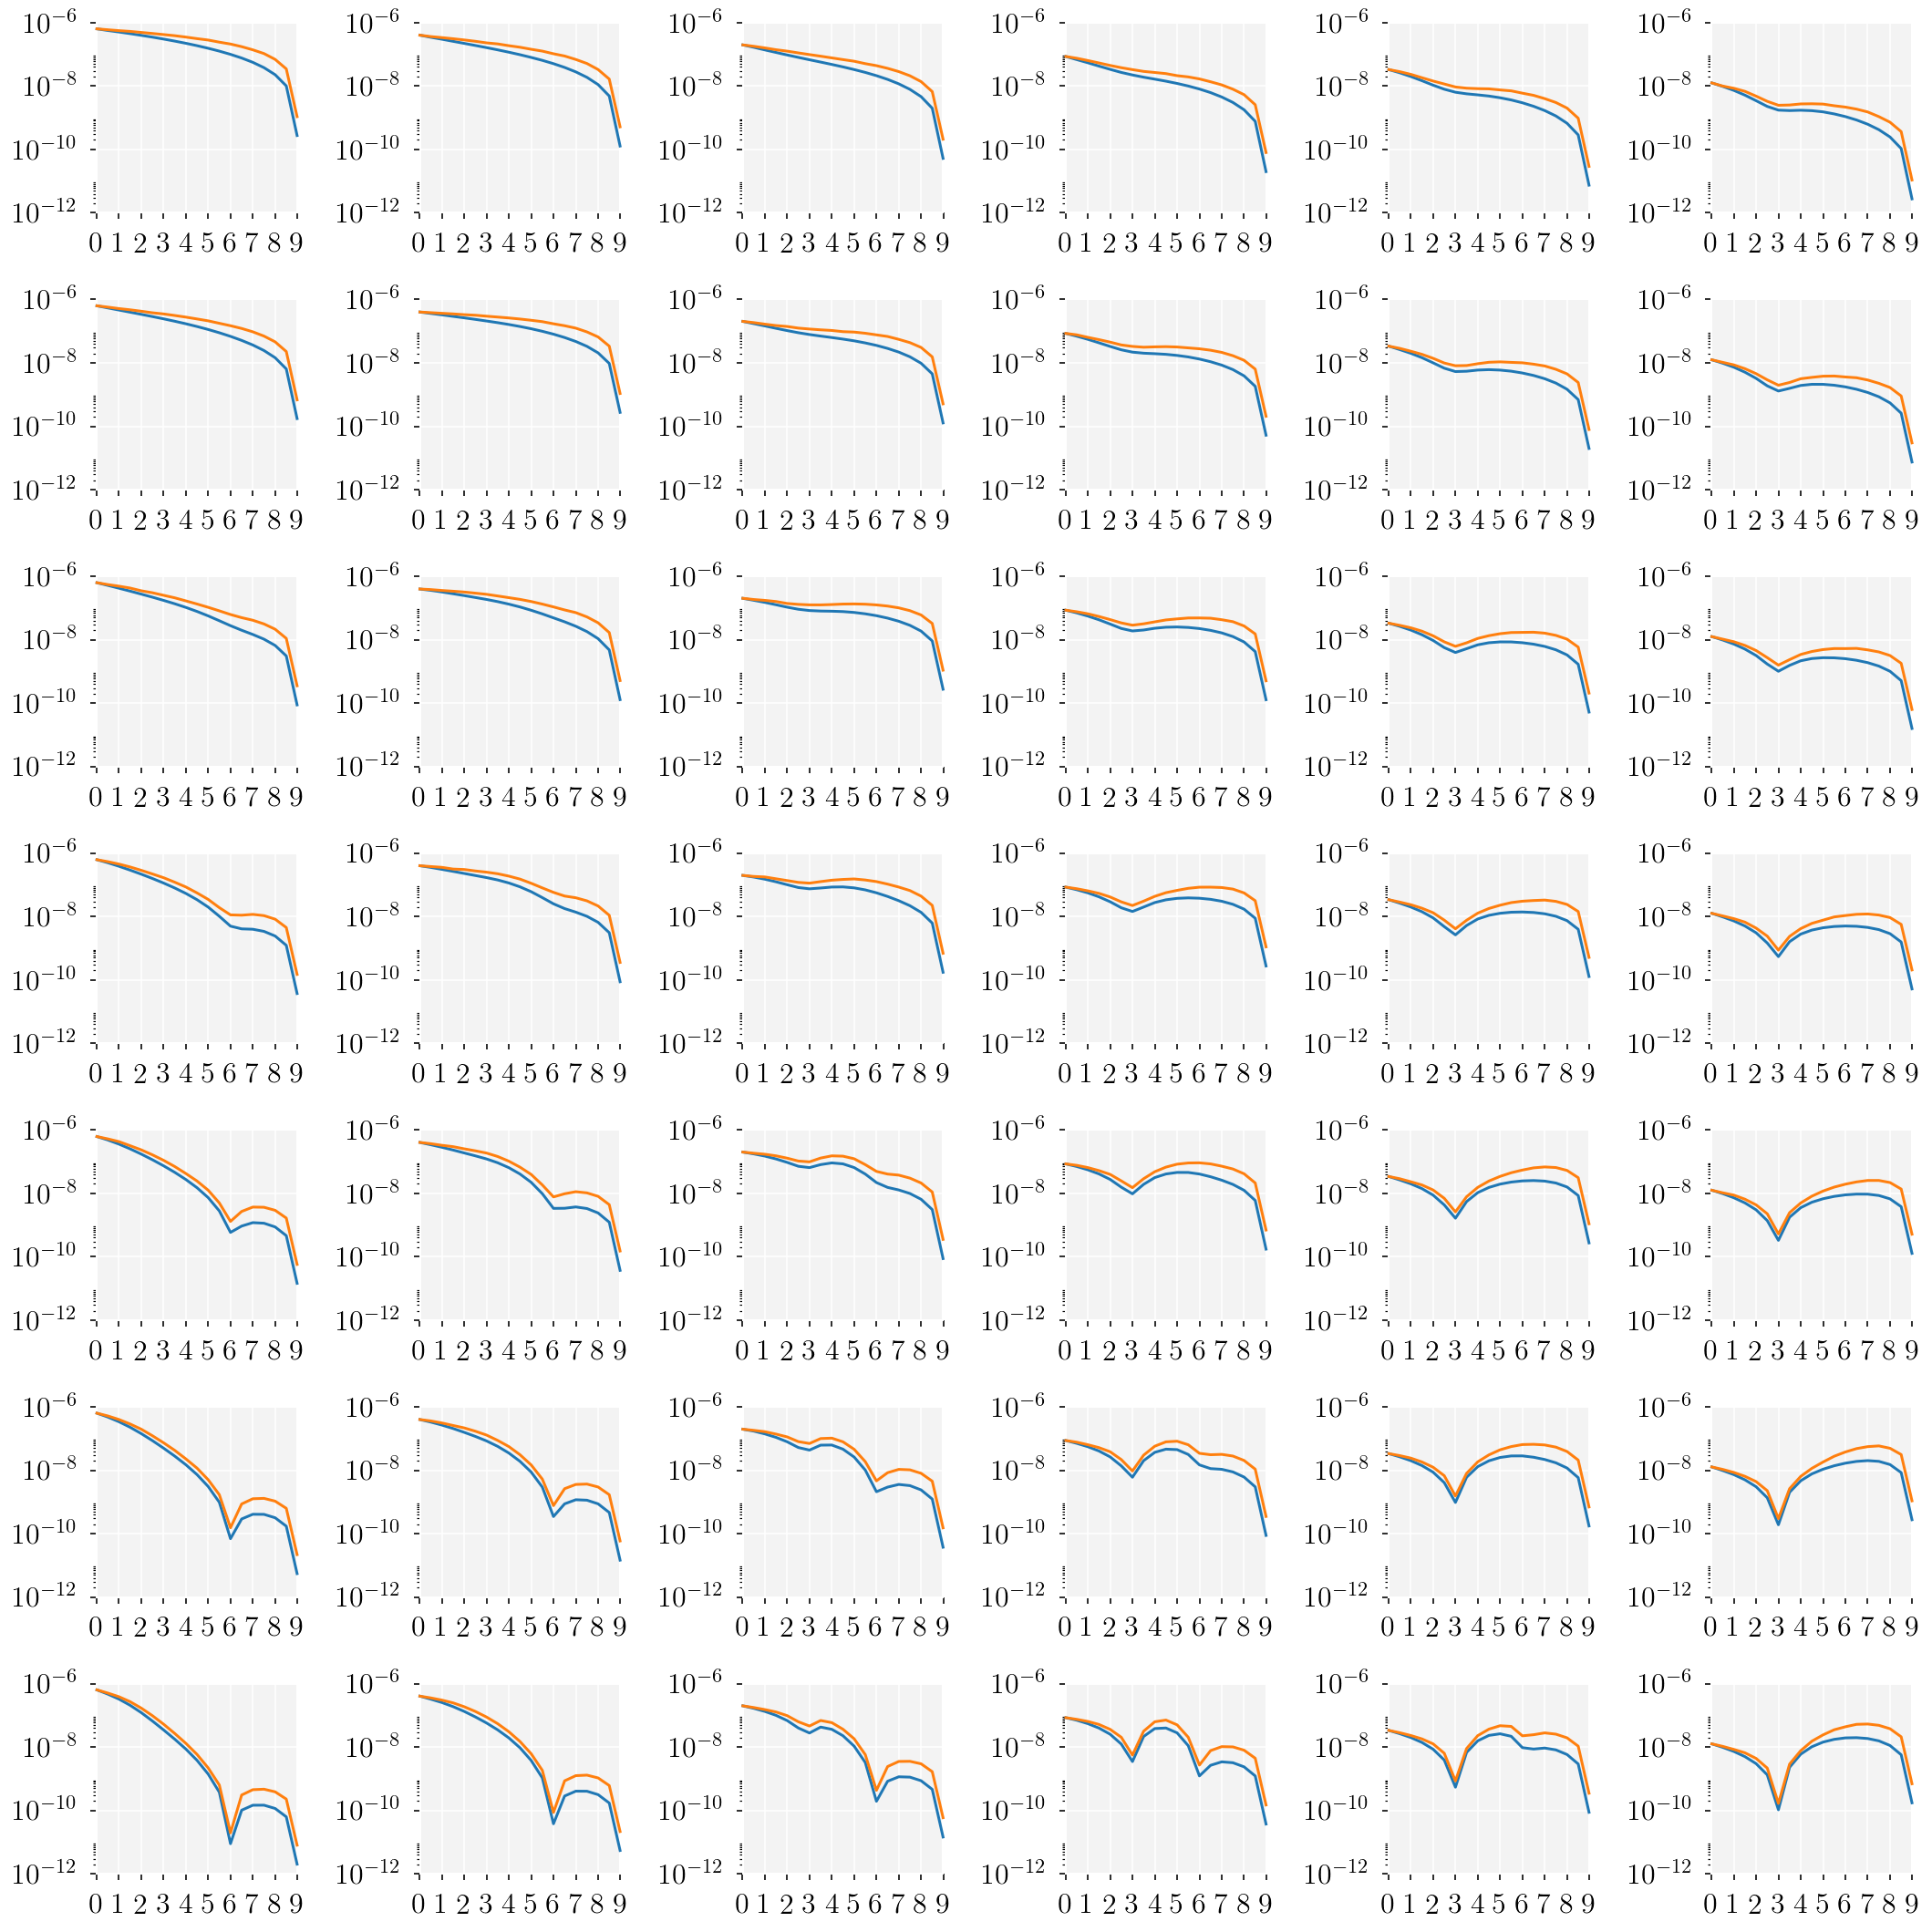

In [14]:
fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (15, 15))
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=['D_t', 'D_coll'], x_range=[0,9], y_range=[1e-12,1e-06], log_plot=True )
    
fig.tight_layout()
fig.savefig( filename = 'diffusion_miniplots.pdf' )

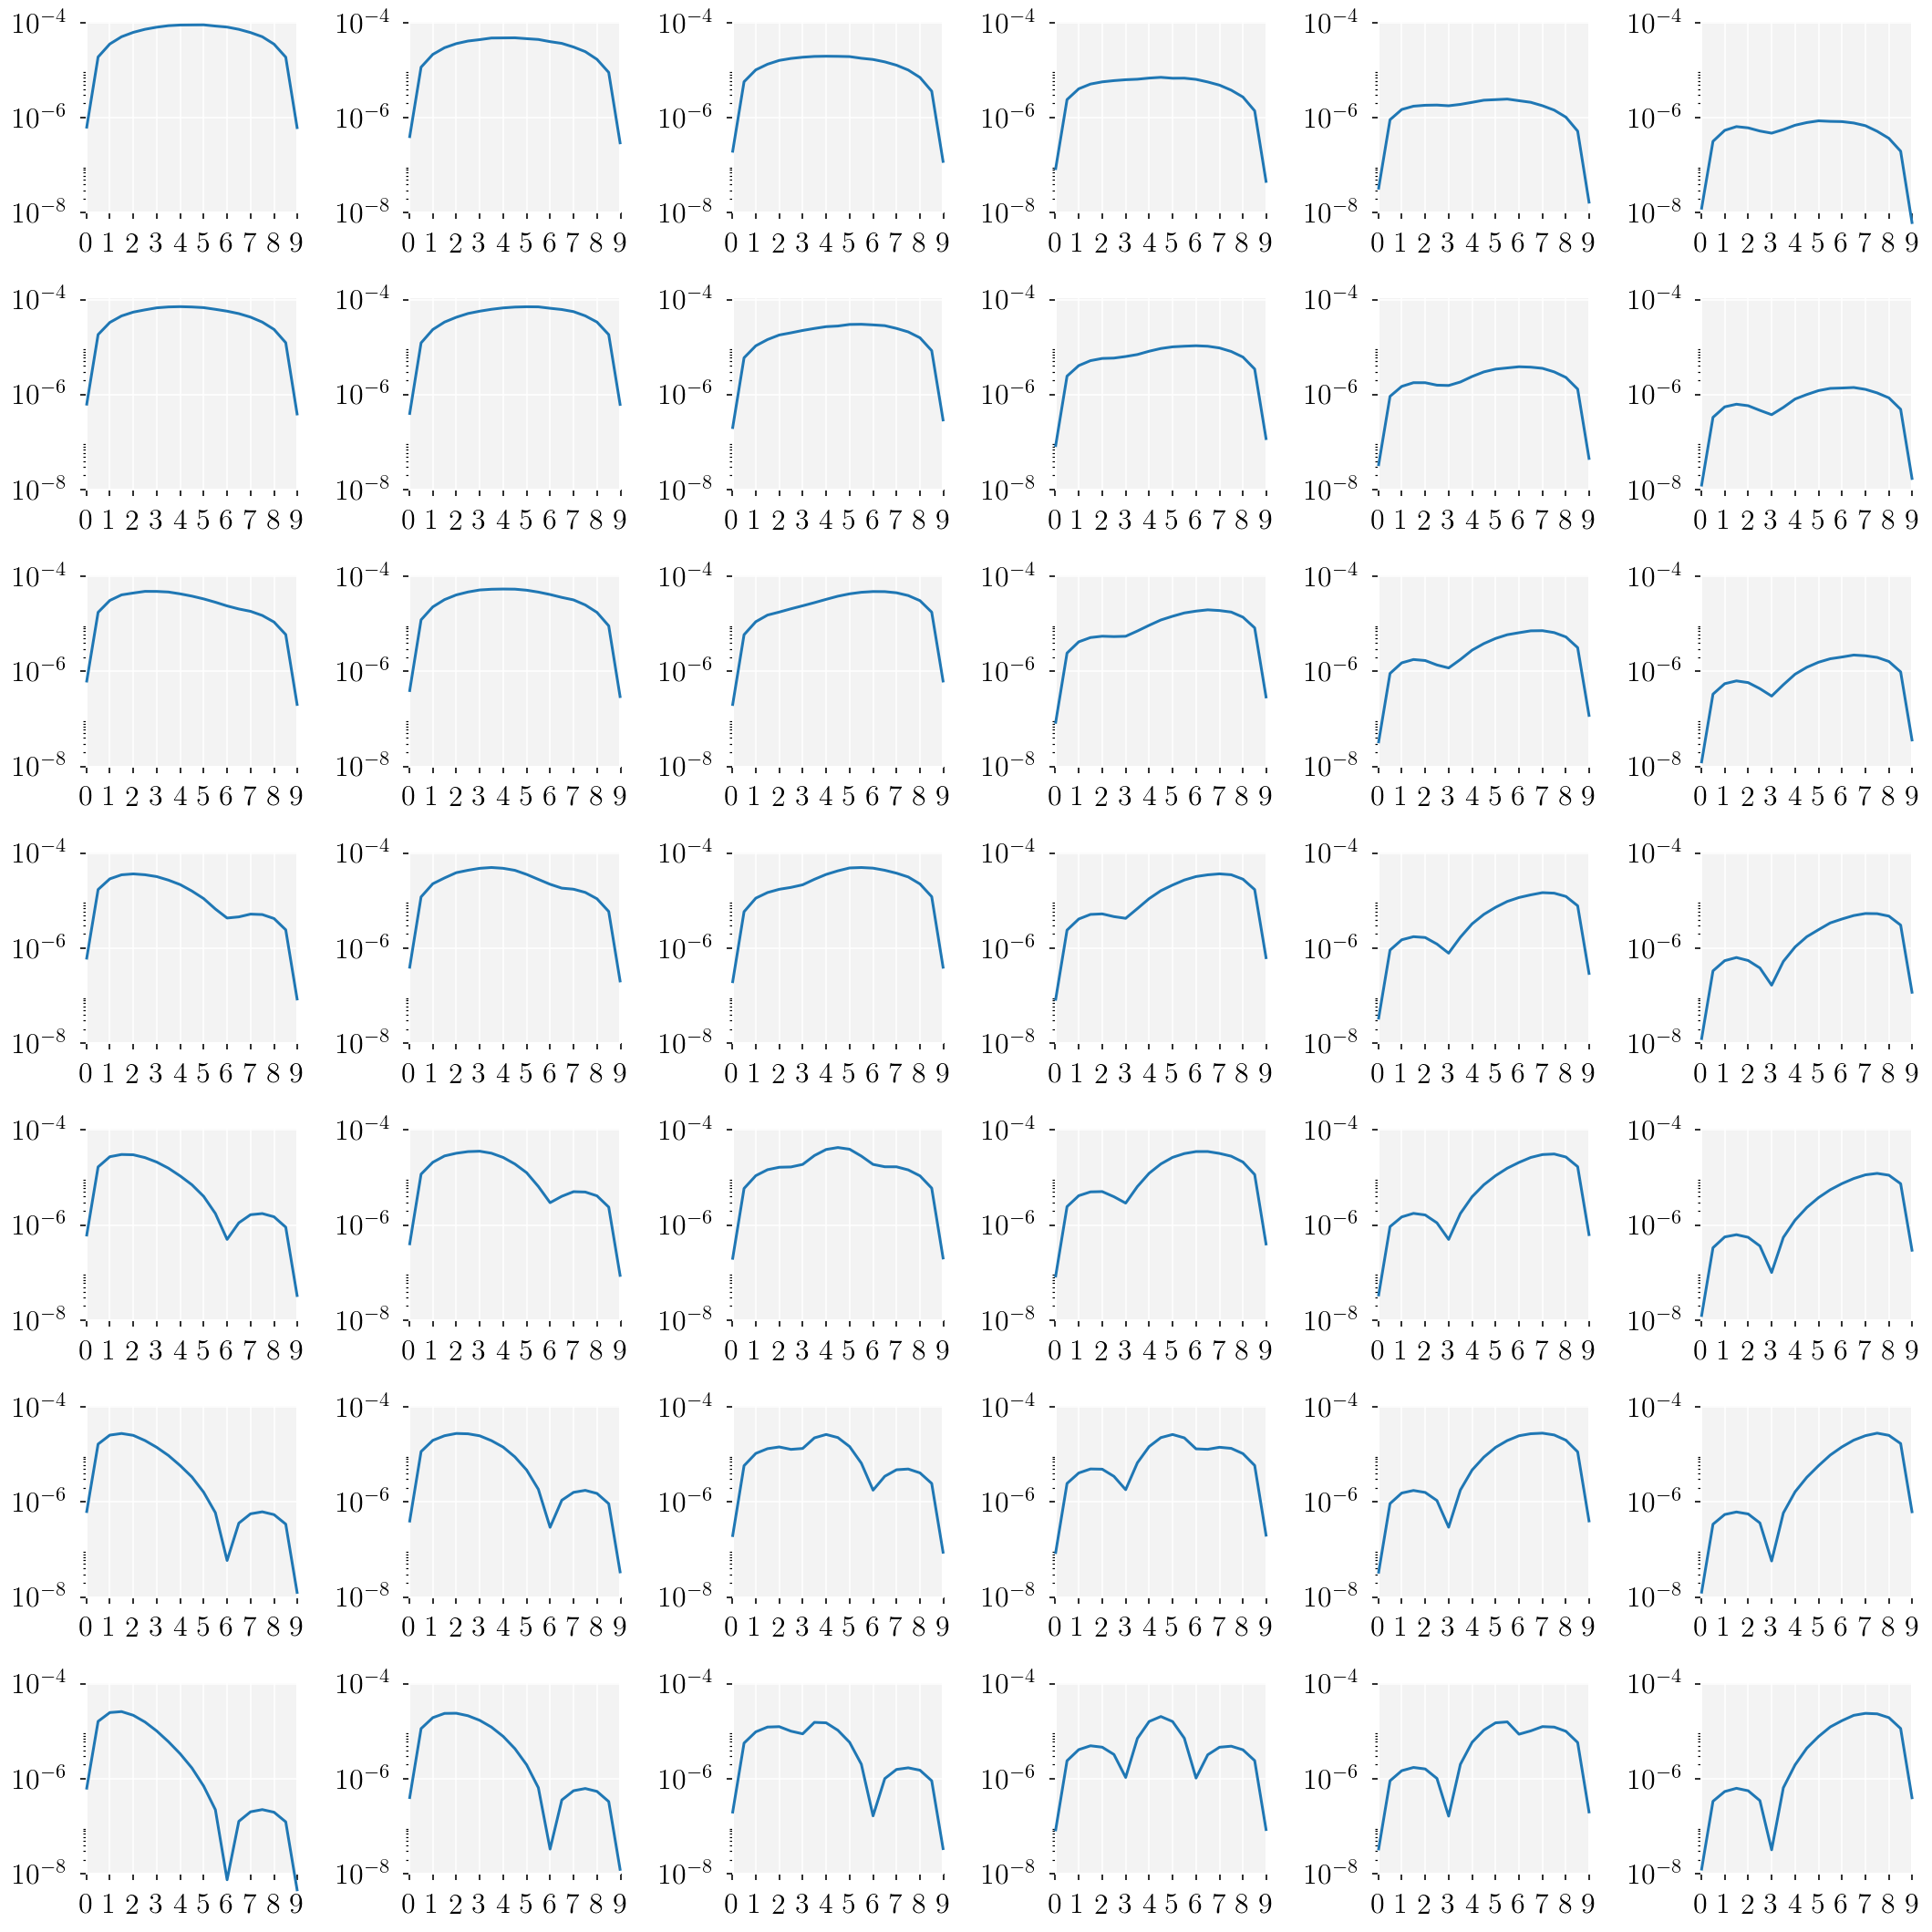

In [15]:
fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (15, 15))
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y='sigma_eff', x_range=[0,9], y_range=[1e-8,1.1e-4], log_plot=True )
    
fig.tight_layout()
fig.savefig( filename = 'conductivity_miniplots.pdf' )

In [16]:
plt.close('all')

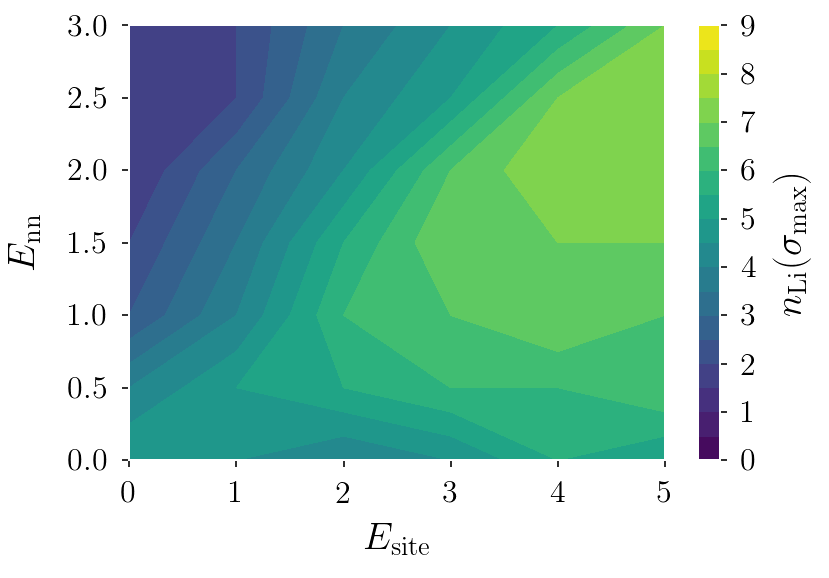

In [17]:
def func( group ):
    return group[ group.sigma_eff == group.sigma_eff.max() ]

ndata_pd = data.groupby( [ 'E_nn', 'E_site' ] ).apply( func ).reset_index( drop = True )
ndata_pd = ndata_pd.sort_values( by = 'E_nn', ascending = False ).pivot( 'E_nn', 'E_site', 'n_Li' )
fig = plt.figure()
ax = fig.add_subplot(111)

ndata = np.nan_to_num( np.array( ndata_pd ) )
# ndata = scipy.ndimage.zoom( ndata, 3)

X = np.linspace( 0, 5.0, 6 )
Y = np.linspace( 0, 3.0, 7 )
Z = ndata
levels = np.linspace( 0.0, 9.0, 19 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )

cs = plt.contourf(x, y, Z, interpolation = 'bicubic', levels = levels, cmap = 'viridis' )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$n_\mathrm{Li}(\sigma_\mathrm{max}$)')

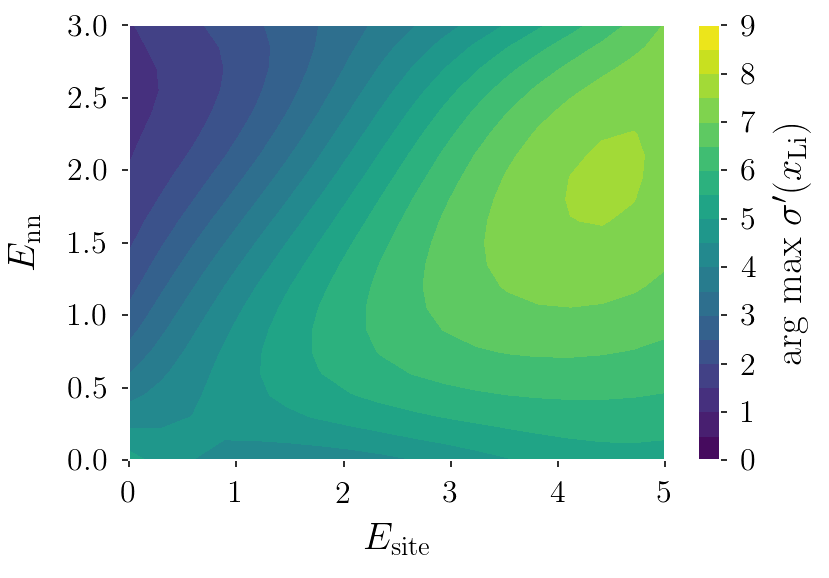

In [18]:
def func( group ):
    return group[ group.sigma_eff == group.sigma_eff.max() ]

ndata_pd = data.groupby( [ 'E_nn', 'E_site' ] ).apply( func ).reset_index( drop = True )
Z = ndata_pd.n_Li.values
Y = ndata_pd.E_nn.values
X = ndata_pd.E_site.values

fig = plt.figure()
ax = fig.add_subplot(111)

xnew, ynew = np.mgrid[0:5.0:18j, 0:3.0:21j]
tck = interpolate.bisplrep( X, Y, Z, s=3 )
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

levels = np.linspace( 0.0, 9.0, 19 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )

cs = plt.contourf(xnew, ynew, znew, interpolation = 'bicubic', levels = levels, cmap = 'viridis' )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$\arg\,\max\,\sigma^\prime(x_\mathrm{Li})$')
fig.savefig( filename = 'max_sigma.pdf' )

/usr/local/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=3,3 nx,ny=9,9 m=42 fp=27.888212 s=3.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


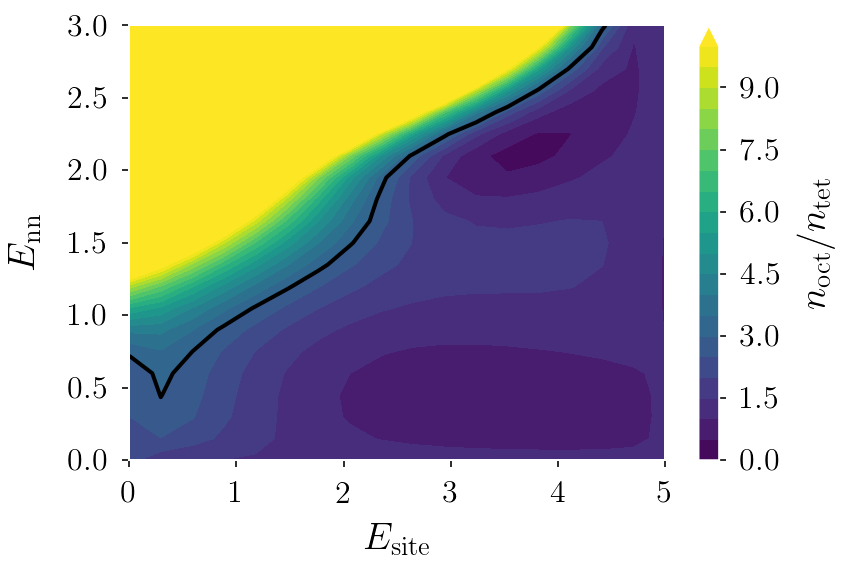

In [19]:
loc = data.n_Li == 6

Z = data[loc].site_ratio.values
Y = ndata_pd.E_nn.values
X = ndata_pd.E_site.values

fig = plt.figure()
ax = fig.add_subplot(111)

xnew, ynew = np.mgrid[0:5.0:18j, 0:3.0:21j]
tck = interpolate.bisplrep( X, Y, Z, s=3 )
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

levels = np.linspace( 0.0, 10.0, 21 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )


cs = plt.contourf(xnew, ynew, znew, interpolation = 'bicubic', levels = levels, cmap = 'viridis', extend = 'max' )
CL = plt.contour(xnew, ynew, znew, levels = [ 3.0 ], linewidths=2, cmap = matplotlib.cm.gray )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$n_\mathrm{oct}/n_\mathrm{tet}$')
fig.savefig( filename = 'max_sigma.pdf' )

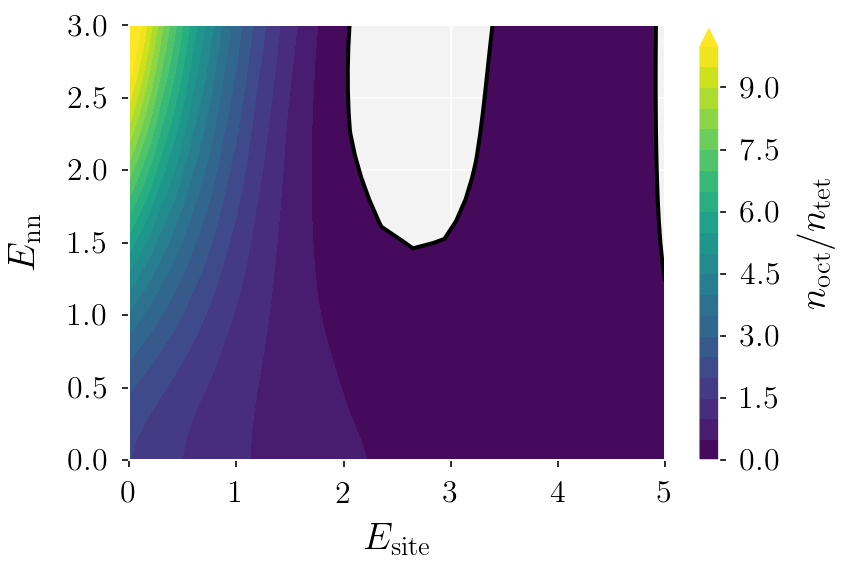

In [20]:
loc = data.n_Li == 3

Z = data[loc].site_ratio.values
Y = ndata_pd.E_nn.values
X = ndata_pd.E_site.values

fig = plt.figure()
ax = fig.add_subplot(111)

xnew, ynew = np.mgrid[0:5.0:18j, 0:3.0:21j]
tck = interpolate.bisplrep( X, Y, Z, s=3 )
znew2 = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

levels = np.linspace( 0.0, 10.0, 21 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )


cs = plt.contourf(xnew, ynew, znew2, interpolation = 'bicubic', levels = levels, cmap = 'viridis', extend = 'max' )
CL = plt.contour(xnew, ynew, znew2, levels = [ 0.0 ], linewidths=2, cmap = matplotlib.cm.gray )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$n_\mathrm{oct}/n_\mathrm{tet}$')
fig.savefig( filename = 'max_sigma.pdf' )

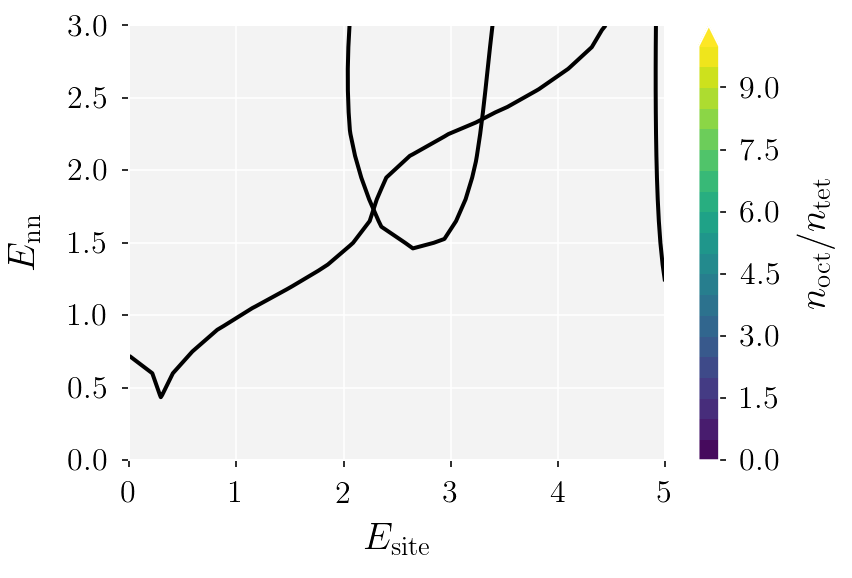

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )

# cs = plt.contourf(xnew, ynew, znew2, interpolation = 'bicubic', levels = levels, cmap = 'viridis', extend = 'max' )
CL1 = plt.contour(xnew, ynew, znew, levels = [ 3.0 ], linewidths=2, cmap = matplotlib.cm.gray )
CL2 = plt.contour(xnew, ynew, znew2, levels = [ 0.0 ], linewidths=2, cmap = matplotlib.cm.gray )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$n_\mathrm{oct}/n_\mathrm{tet}$')

In [22]:
plt.close('all')